<a href="https://colab.research.google.com/github/Abishethvarman/FakeNewsDetection/blob/main/V1_1_Sentiment_Analysis_VADER_FakeNews_Full_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sentiment Analysis on VADER https://www.youtube.com/watch?v=QpzMWQvxXWk
VADER crashed in 68% percentage  
10.58-6.20
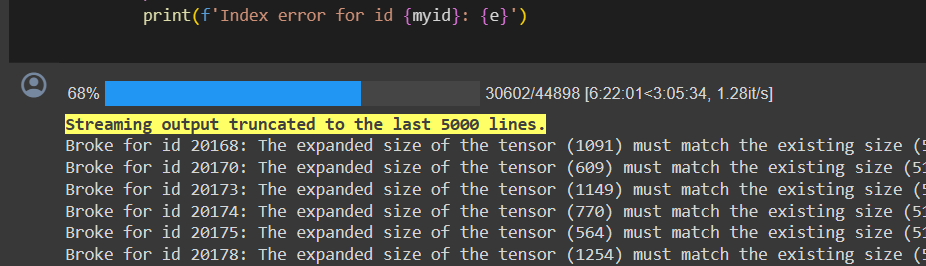

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import gensim
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

import plotly.express as px
from tqdm.notebook import tqdm

plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [ ]:
df_reliable = pd.read_csv("Reliable.csv")
df_fake = pd.read_csv("Fake.csv")

In [ ]:
df_reliable['isfake'] = 0
df_fake['isfake'] = 1

In [ ]:
df_reliable.shape

(21417, 5)

In [ ]:
df_fake.shape

(23481, 5)

In [ ]:
print(df_reliable['subject'].unique())
print(df_fake['subject'].unique())

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


In [ ]:
df = pd.concat([df_reliable, df_fake]).reset_index(drop = True)

In [ ]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  
0      December 31, 2017        0  
1      December 29, 2017        0  
2      December 31, 2017        0  
3      December 30, 2017        0  
4      December 29, 2017        0  
...                   ...     ...  
44893    January 16, 2016       1  
44894    January 16, 2016       1  
44895    January 15, 2016       1  
44896    January 14, 2016       1  
44897    January 12, 2016       1  

[44898 rows x 5 columns]

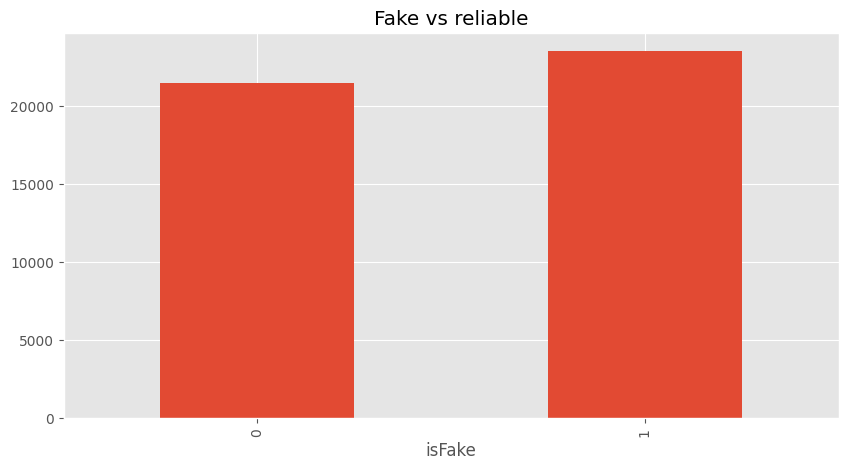

In [ ]:
ax = df['isfake'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake vs reliable',
          figsize=(10, 5))
ax.set_xlabel('isFake')
plt.show()

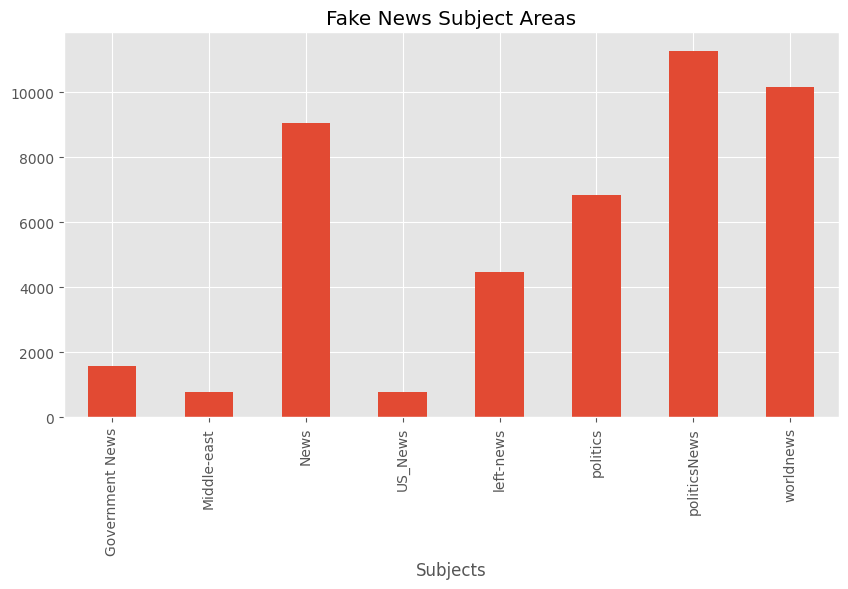

In [ ]:
ax = df['subject'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Fake News Subject Areas',
          figsize=(10, 5))
ax.set_xlabel('Subjects')
plt.show()

In [ ]:
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  isfake  \
0  December 31, 2017        0   
1  December 29, 2017        0   
2  December 31, 2017        0   
3  December 30, 2017        0   
4  December 29, 2017        0   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
from gensim.parsing.preprocessing import STOPWORDS, remove_stopword_tokens
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            result.append(token)

    return result


In [ ]:
# Apply the function to the dataframe
df['clean'] = df['original'].apply(preprocess)

In [ ]:
print(df['clean'][0])

['budget', 'fight', 'looms', 'republicans', 'flip', 'fiscal', 'script', 'washington', 'reuters', 'head', 'conservative', 'republican', 'faction', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'budget', 'increase', 'military', 'spending', 'democrats', 'want', 'proportional', 'increases', 'defense', 'discretionary', 'spending', 'programs', 'support', 'educati

In [ ]:
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [ ]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [ ]:
len(list_of_words)
total_words = len(list(set(list_of_words)))
total_words

108704

In [ ]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  isfake  \
0      December 31, 2017        0   
1      December 29, 2017        0   
2      December 31, 2017        0   
3      December 30, 2017        0   
4      December 29, 2017        0   
...                   ...     ...   
44893    January 16, 2016       1   
44894    January 16, 2016       1   
44895    January 15, 2016       1   
44896    January 14, 2016       1   
44897    January 12, 2016       1   

                                                original  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
0      [budget, fight, looms, republicans, flip, fisc...   
1      [military, accept, transgender, recruits, mond...   
2      [senior, republican, senator, mueller, washing...   
3      [russia, probe, helped, australian, diplomat, ...   
4      [trump, wants, postal, service, charge, amazon...   
...                                                  ...   
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
0      budget fight looms republicans flip fiscal scr...  
1      military accept transgender recruits monday pe...  
2      senior republican senator mueller washington r...  
3      russia probe helped australian diplomat washin...  
4      trump wants postal service charge amazon shipm...  
...                                                  ...  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied

In [ ]:
example = df['clean_joined']
print(example)

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller washington r...
3        russia probe helped australian diplomat washin...
4        trump wants postal service charge amazon shipm...
                               ...                        
44893    mcpain john mccain furious iran treated sailor...
44894    justice yahoo settles mail privacy class actio...
44895    sunnistan allied safe zone plan territorial bo...
44896    blow million jazeera america finally calls qui...
44897    navy sailors held iranian military signs neoco...
Name: clean_joined, Length: 44898, dtype: object


In [ ]:
# tokens = nltk.word_tokenize(example)
tokens = nltk.word_tokenize(str(example))
tokens[:10]

['0',
 'budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'scr',
 '...',
 '1']

In [ ]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('0', 'CD'),
 ('budget', 'NN'),
 ('fight', 'NN'),
 ('looms', 'VBZ'),
 ('republicans', 'NNS'),
 ('flip', 'JJ'),
 ('fiscal', 'JJ'),
 ('scr', 'NN'),
 ('...', ':'),
 ('1', 'CD')]

In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  0/CD
  budget/NN
  fight/NN
  looms/VBZ
  republicans/NNS
  flip/JJ
  fiscal/JJ
  scr/NN
  .../:
  1/CD
  military/JJ
  accept/NN
  transgender/NN
  recruits/NNS
  monday/VBP
  pe/NN
  .../:
  2/CD
  senior/JJ
  republican/JJ
  senator/NN
  mueller/NN
  washington/NN
  r/NN
  .../:
  3/CD
  russia/NN
  probe/NN
  helped/VBD
  australian/JJ
  diplomat/NN
  washin/NN
  .../:
  4/CD
  trump/NN
  wants/VBZ
  postal/JJ
  service/NN
  charge/NN
  amazon/JJ
  shipm/NN
  .../:
  .../:
  44893/CD
  mcpain/NN
  john/NN
  mccain/VBP
  furious/JJ
  iran/NN
  treated/VBD
  sailor/NN
  .../:
  44894/CD
  justice/NN
  yahoo/NN
  settles/NNS
  mail/VBP
  privacy/NN
  class/NN
  actio/NN
  .../:
  44895/CD
  sunnistan/NN
  allied/VBD
  safe/JJ
  zone/NN
  plan/NN
  territorial/JJ
  bo/NN
  .../:
  44896/CD
  blow/NN
  million/CD
  jazeera/NN
  america/NN
  finally/RB
  calls/VBZ
  qui/NN
  .../:
  44897/CD
  navy/JJ
  sailors/NNS
  held/VBD
  iranian/JJ
  military/JJ
  signs/NNS
  neoco/VBP
  .../

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
sia.polarity_scores('As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non')

{'neg': 0.101, 'neu': 0.84, 'pos': 0.059, 'compound': -0.7269}

In [ ]:
sia.polarity_scores(str(example))

{'neg': 0.087, 'neu': 0.796, 'pos': 0.117, 'compound': 0.4019}

In [ ]:
df['id'] = df.index + 1

In [ ]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/44898 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.tail()

id    neg    neu    pos  compound  \
44893  44894  0.102  0.787  0.111    0.7675   
44894  44895  0.054  0.853  0.093    0.9429   
44895  44896  0.130  0.767  0.103   -0.9994   
44896  44897  0.081  0.834  0.085    0.4589   
44897  44898  0.136  0.806  0.057   -0.9978   

                                                   title  \
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
44893  21st Century Wire says As 21WIRE reported earl...  Middle-east   
44894  21st Century Wire says It s a familiar theme. ...  Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
44896  21st Century Wire says Al Jazeera America will...  Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                   date  isfake  \
44893  January 16, 2016       1   
44894  January 16, 2016       1   
44895  January 15, 2016       1   
44896  January 14, 2016       1   
44897  January 12, 2016       1   

                                                original  \
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  \
44893  [mcpain, john, mccain, furious, iran, treated,...   
44894  [justice, yahoo, settles, mail, privacy, class...   
44895  [sunnistan, allied, safe, zone, plan, territor...   
44896  [blow, million, jazeera, america, finally, cal...   
44897  [navy, sailors, held, iranian, military, signs...   

                                            clean_joined  
44893  mcpain john mccain furious iran treated sailor...  
44894  justice yahoo settles mail privacy class actio...  
44895  sunnistan allied safe zone plan territorial bo...  
44896  blow million jazeera america finally calls qui...  
44897  navy sailors held iranian military signs neoco...

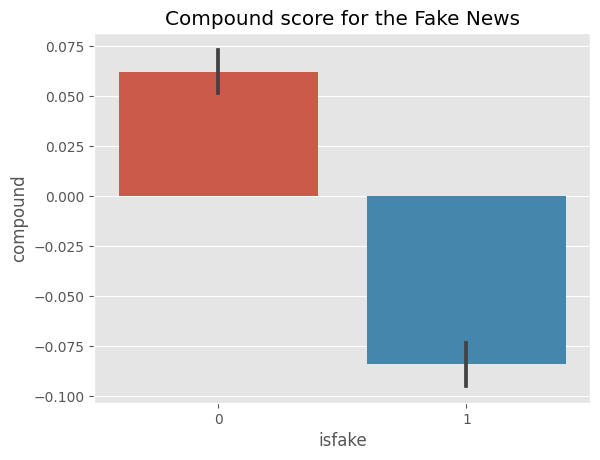

In [ ]:
ax = sns.barplot(data=vaders, x='isfake', y='compound')
ax.set_title('Compound score for the Fake News')
plt.show()

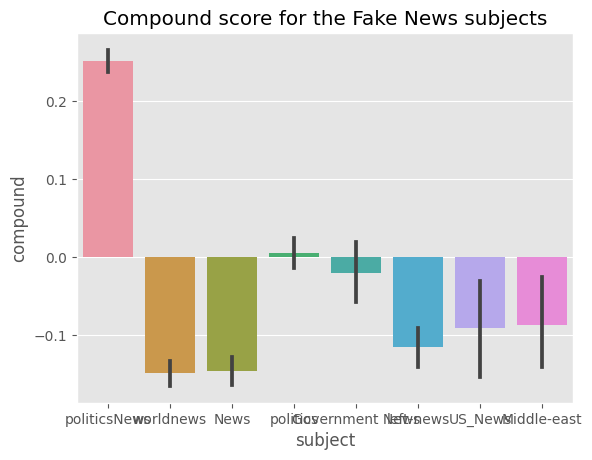

In [ ]:
ax = sns.barplot(data=vaders, x='subject', y='compound')
ax.set_title('Compound score for the Fake News subjects')
plt.show()

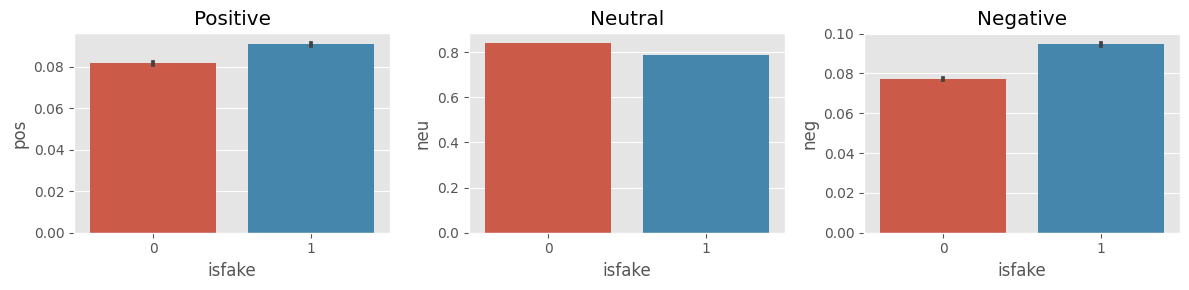

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='isfake', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='isfake', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='isfake', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# VADER results on example
print(example)
sia.polarity_scores(str(example))

0        budget fight looms republicans flip fiscal scr...
1        military accept transgender recruits monday pe...
2        senior republican senator mueller washington r...
3        russia probe helped australian diplomat washin...
4        trump wants postal service charge amazon shipm...
                               ...                        
44893    mcpain john mccain furious iran treated sailor...
44894    justice yahoo settles mail privacy class actio...
44895    sunnistan allied safe zone plan territorial bo...
44896    blow million jazeera america finally calls qui...
44897    navy sailors held iranian military signs neoco...
Name: clean_joined, Length: 44898, dtype: object


{'neg': 0.087, 'neu': 0.796, 'pos': 0.117, 'compound': 0.4019}

In [ ]:
# Run for Roberta Model
encoded_text = tokenizer(str(example), return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.24135256, 'roberta_neu': 0.7031134, 'roberta_pos': 0.05553405}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

# First 500 texts
# res = {}
# num_rows_to_process = 500

# for i, row in tqdm(df.head(num_rows_to_process).iterrows(), total=num_rows_to_process):
#     try:
#         text = row['text']
#         myid = row['id']
#         vader_result = sia.polarity_scores(text)
#         vader_result_rename = {}
#         for key, value in vader_result.items():
#             vader_result_rename[f"vader_{key}"] = value
#         roberta_result = polarity_scores_roberta(text)
#         both = {**vader_result_rename, **roberta_result}
#         res[myid] = both
#     except RuntimeError:
#         print(f'Broke for id {myid}')


  0%|          | 0/44898 [00:00<?, ?it/s]

Broke for id 1
Broke for id 2
Broke for id 3
Broke for id 5
Broke for id 6
Broke for id 7
Broke for id 12
Broke for id 16
Broke for id 17
Broke for id 21
Broke for id 22
Broke for id 25
Broke for id 30
Broke for id 35
Broke for id 36
Broke for id 37
Broke for id 38
Broke for id 39
Broke for id 43
Broke for id 45
Broke for id 47
Broke for id 52
Broke for id 53
Broke for id 55
Broke for id 59
Broke for id 60
Broke for id 61
Broke for id 63
Broke for id 65
Broke for id 66
Broke for id 67
Broke for id 68
Broke for id 72
Broke for id 75
Broke for id 76
Broke for id 77
Broke for id 78
Broke for id 80
Broke for id 81
Broke for id 84
Broke for id 86
Broke for id 88
Broke for id 93
Broke for id 98
Broke for id 100
Broke for id 101
Broke for id 102
Broke for id 109
Broke for id 110
Broke for id 114
Broke for id 115
Broke for id 118
Broke for id 126
Broke for id 128
Broke for id 129
Broke for id 136
Broke for id 139
Broke for id 140
Broke for id 142
Broke for id 143
Broke for id 144
Broke for id 

IndexError: ignored

In [ ]:
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['text']
        myid = row['id']

        # Check for empty or very short texts
        if not text or len(text) < 3:
            print(f'Skipping empty or very short text for id {myid}')
            continue

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value

        roberta_result = polarity_scores_roberta(text)

        both = {**vader_result_rename, **roberta_result}
        res[myid] = both

    except RuntimeError as e:
        print(f'Broke for id {myid}: {e}')
    except IndexError as e:
        print(f'Index error for id {myid}: {e}')


  0%|          | 0/44898 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Broke for id 20168: The expanded size of the tensor (1091) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1091].  Tensor sizes: [1, 514]
Broke for id 20170: The expanded size of the tensor (609) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 609].  Tensor sizes: [1, 514]
Broke for id 20173: The expanded size of the tensor (1149) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 1149].  Tensor sizes: [1, 514]
Broke for id 20174: The expanded size of the tensor (770) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 770].  Tensor sizes: [1, 514]
Broke for id 20175: The expanded size of the tensor (564) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 564].  Tensor sizes: [1, 514]
Broke for id 20178: The expanded size of the tensor (1254) must match the existing si

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(df, how='left')

NameError: ignored

In [ ]:
results_df.columns

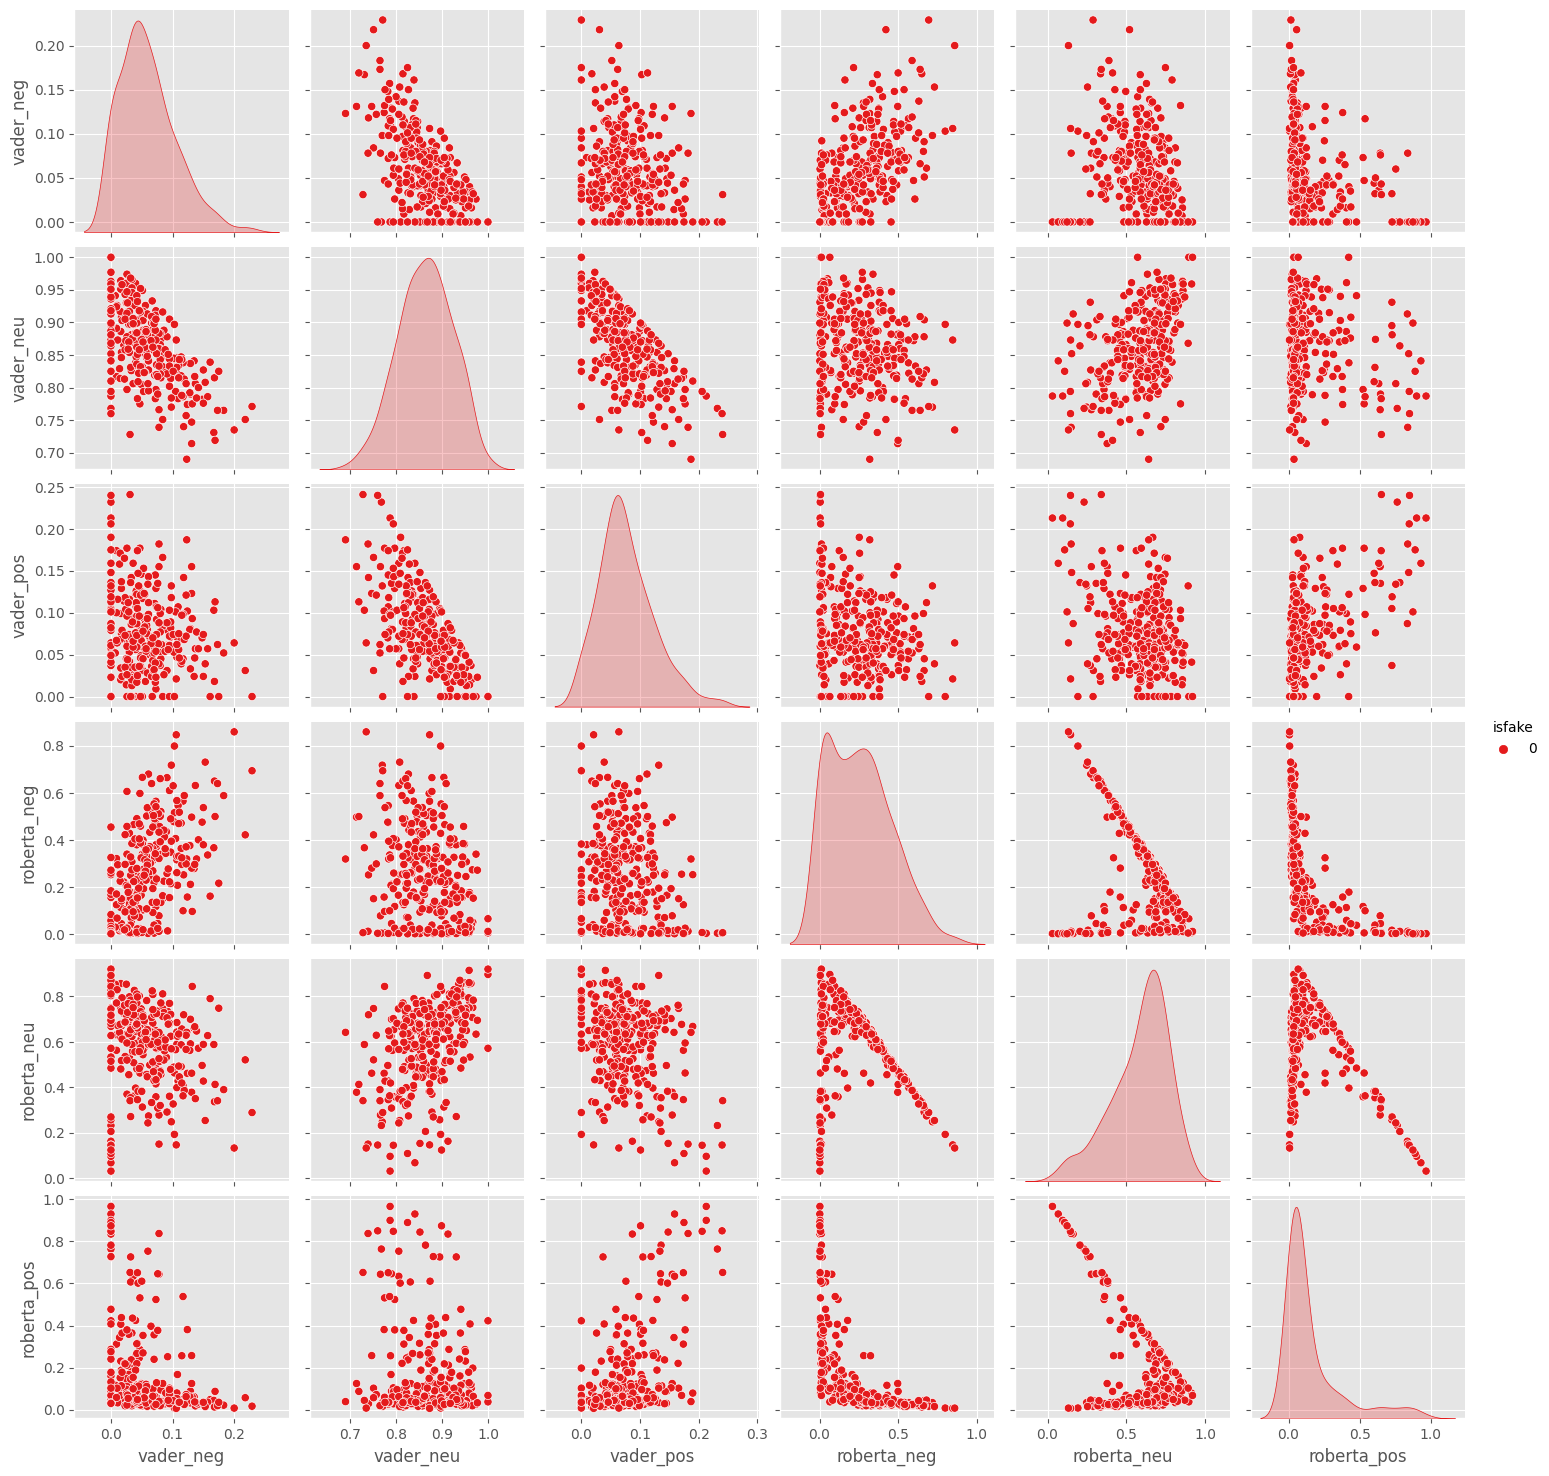

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue='isfake',
            palette='Set1')
plt.show()

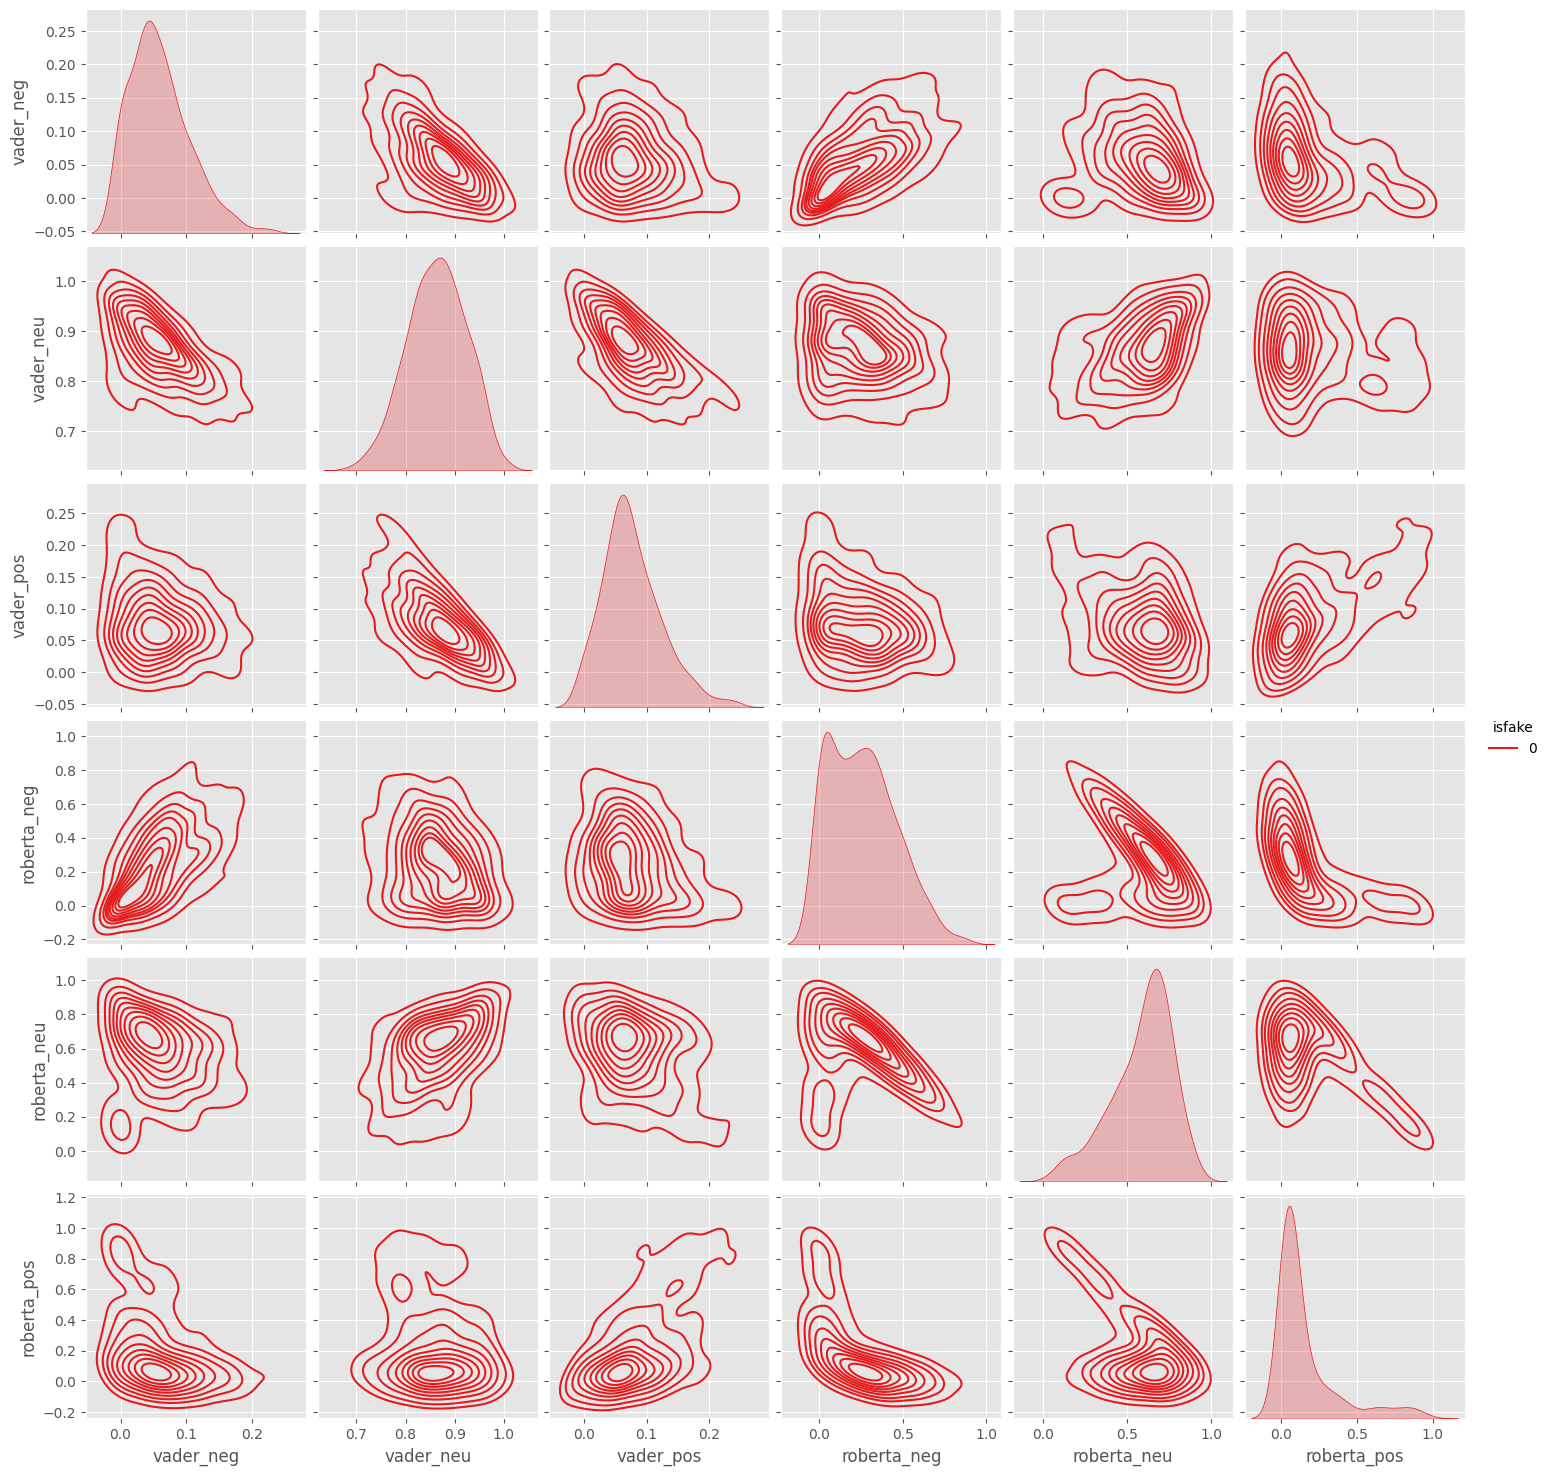

In [ ]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos',],
            hue='isfake',
            kind="kde",
            palette='Set1')
plt.show()

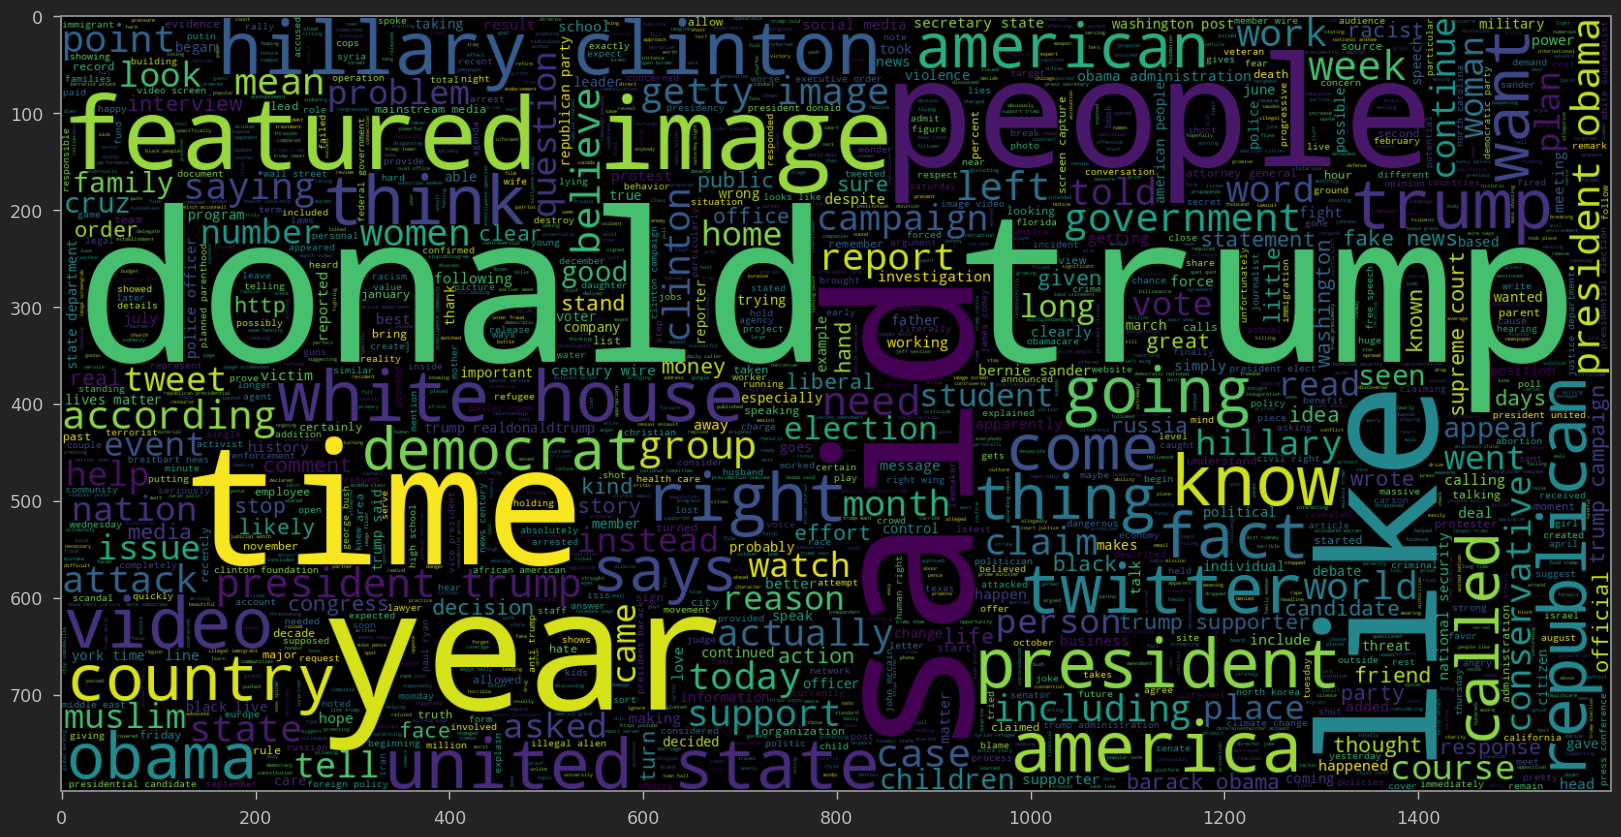

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

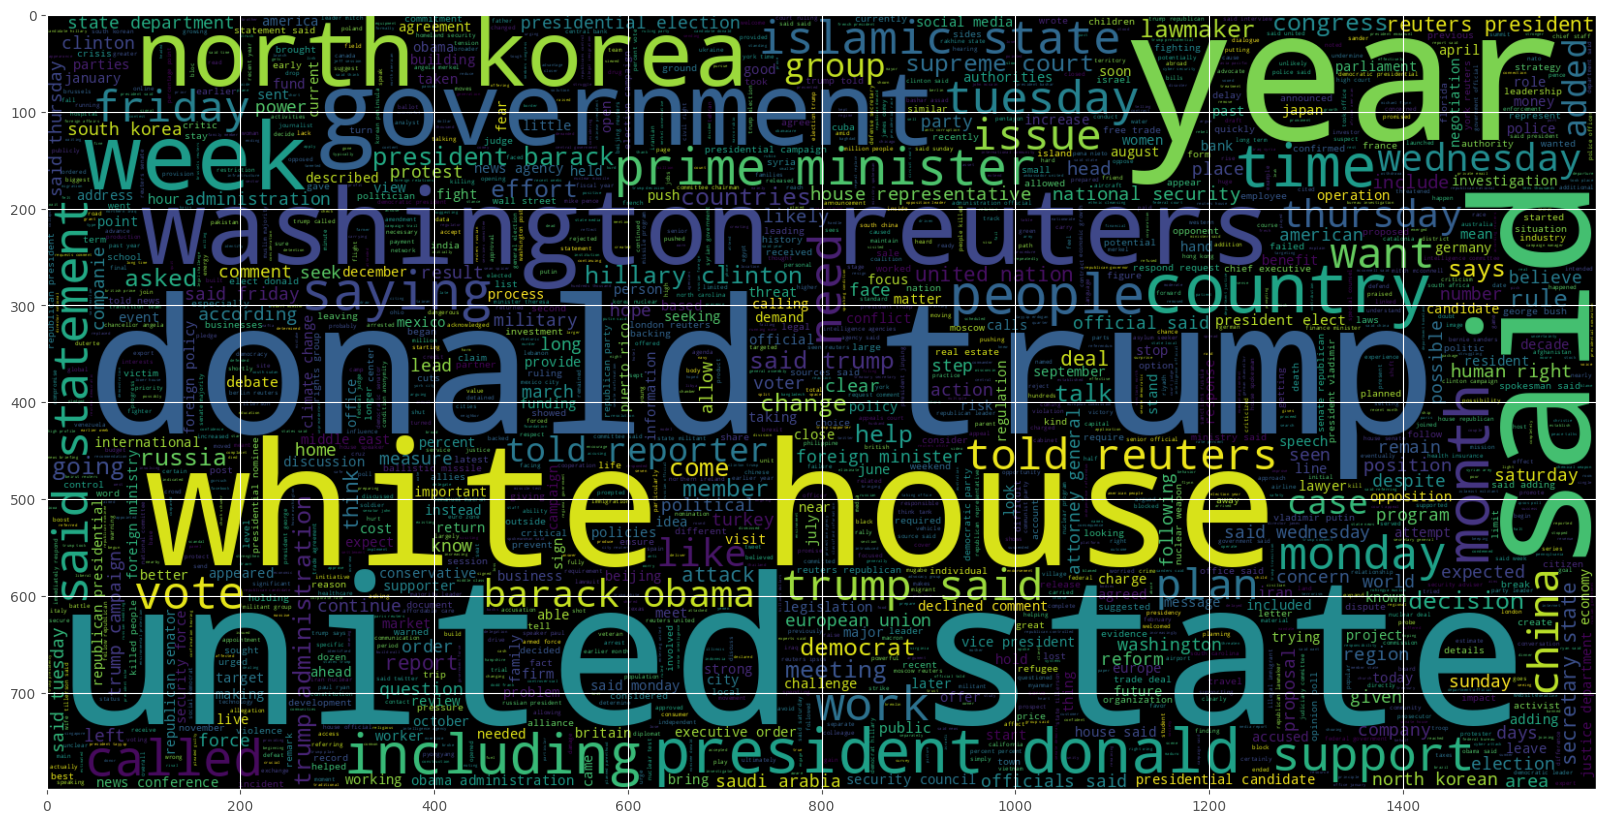

In [ ]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.isfake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
maxlen = -1
for doc in df.clean_joined:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


In [ ]:
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined], nbins = 100)
fig.show()

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis on 'original' column and store the compound score in 'vader_score'
df['vader_score'] = df['clean_joined'].apply(lambda x: sid.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


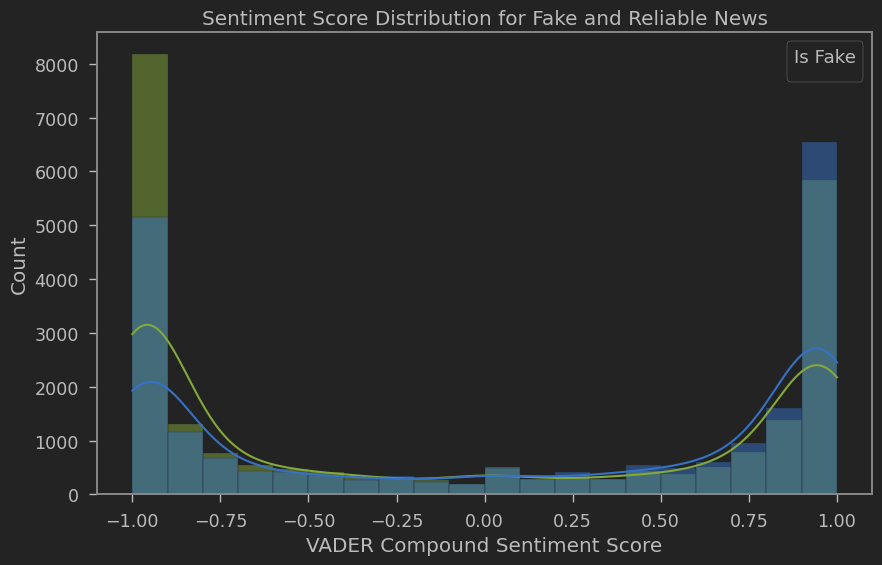

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='vader_score', hue='isfake', kde=True, bins=20)
plt.title('Sentiment Score Distribution for Fake and Reliable News')
plt.xlabel('VADER Compound Sentiment Score')
plt.legend(title='Is Fake')
plt.show()

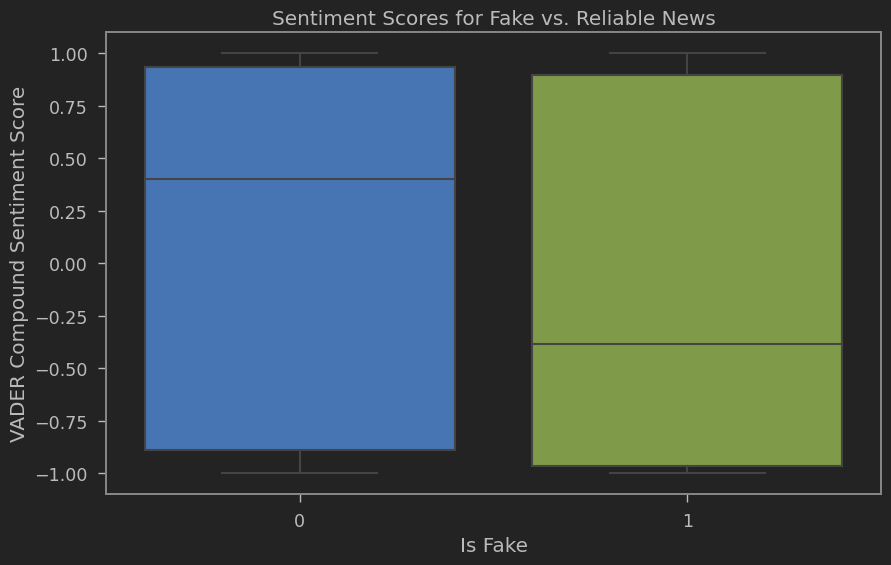

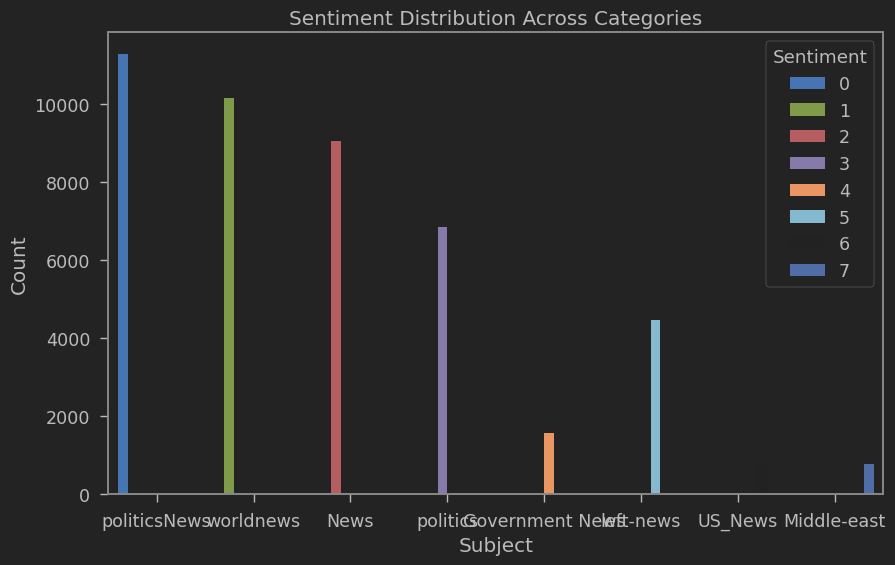

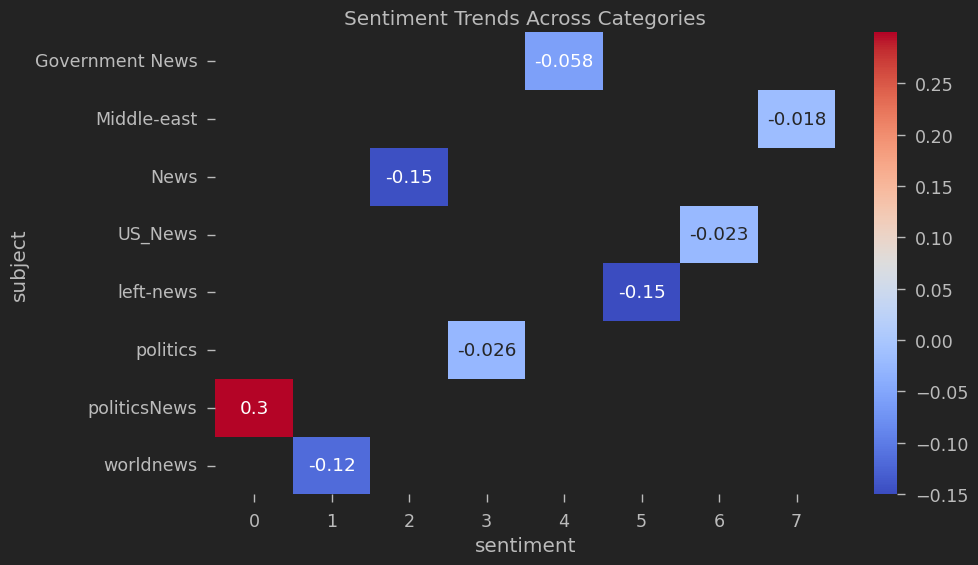

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Box plot of sentiment scores for fake and reliable news
plt.figure(figsize=(10, 6))
sns.boxplot(x='isfake', y='vader_score', data=df)
plt.title('Sentiment Scores for Fake vs. Reliable News')
plt.xlabel('Is Fake')
plt.ylabel('VADER Compound Sentiment Score')
plt.show()

# Bar plot showing counts of positive, negative, and neutral sentiments for each category
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='sentiment', data=df)
plt.title('Sentiment Distribution Across Categories')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# Scatter plot of sentiment scores vs. text length
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='text_length', y='vader_score', data=df)
# plt.title('Sentiment Score vs. Text Length')
# plt.xlabel('Text Length')
# plt.ylabel('VADER Compound Sentiment Score')
# plt.show()

# Heatmap for sentiment trends across categories
heatmap_data = df.pivot_table(index='subject', columns='sentiment', values='vader_score', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True)
plt.title('Sentiment Trends Across Categories')
plt.show()


In [ ]:
# split data into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)
from nltk import word_tokenize


In [ ]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [ ]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post')
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [    1  1093  1609  2850  5308    32   147  7661    25     9    10     1
 22567   580    34   624   469    15     8  2452    94   258    32  1093
  3459  1609  2850  5328  8296   947    32  2935   441     1   319  4721
    19  1233    13    47]
The padded encoding for document 2  is :  [  618    31   353   392    48  1167  9250    46   149  3690     9   618
    31   353   392    48  1167   786  9250   651   126   325    17   273
     2    85  7575  5743   120  1007   283  1094  2182  1302  2278   871
 49711   618  3382   426]


In [ ]:
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))


# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         13914112  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 14,210,305
Trainable params: 14,210,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
total_words

108704

In [ ]:
y_train = np.asarray(y_train)
# train the model
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 274s 534ms/step - loss: 0.0444 - acc: 0.9834 - val_loss: 0.0075 - val_acc: 0.9978
Epoch 2/2
506/506 [==============================] - 275s 545ms/step - loss: 0.0023 - acc: 0.9996 - val_loss: 0.0045 - val_acc: 0.9983


In [ ]:
# make detection
detect = model.predict(padded_test)
# if the predicted value is >0.5 it is real else it is fake
detection = []
for i in range(len(detect)):
    if detect[i].item() > 0.5:
        detection.append(1)
    else:
        detection.append(0)
# getting the accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), detection)

print("Model Accuracy : ", accuracy)

281/281 [==============================] - 16s 55ms/step
Model Accuracy :  0.9985523385300669


In [ ]:
# get the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(list(y_test), detection)
plt.figure(figsize = (25, 25))
sns.heatmap(cm, annot = True)

In [ ]:
# category dict
category = { 0: 'Fake News', 1 : "Reliable News"}


In [ ]:
def load_model_and_tokenizer():
    # Load the tokenizer and total_words from the previous code
    total_words = ...

    tokenizer = Tokenizer(num_words=total_words)
    model = Sequential()
    model.add(Embedding(total_words, output_dim=128))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # Load the weights for the trained model
    model.load_weights("path_to_model_weights")  # Replace "path_to_model_weights" with the actual path of the model weights file

    return tokenizer, model

In [ ]:
# Function to preprocess and classify the news article
def classify_news_input(input_text, tokenizer, model):
    processed_text = preprocess(input_text)
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=40, padding='post', truncating='post')
    prediction = model.predict(padded_sequences)
    return "Reliable News" if prediction.item() > 0.5 else "Fake News"

# Call the function to load the tokenizer and model
tokenizer, model = load_model_and_tokenizer()

# Test with user input
user_input = input("Enter a news article for classification: ")
result = classify_news_input(user_input, tokenizer, model)
print("The news article is classified as:", result)

TypeError: ignored

-------------------------------------

In [ ]:
def classify_news(input_text, tokenizer, model):
    # Preprocess the input text
    processed_text = preprocess(input_text)

    # Tokenize and pad the processed text
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=40, padding='post', truncating='post')

    # Make prediction using the loaded model
    prediction = model.predict(padded_sequences)

    # If the predicted value is greater than 0.5, it is classified as "Reliable News",
    # otherwise, it is classified as "Fake News"
    if prediction.item() > 0.5:
        return "Reliable News"
    else:
        return "Fake News"


# Call the function to load the tokenizer and model
tokenizer, model = load_model_and_tokenizer()

TypeError: ignored

In [ ]:


# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "This is a fake news article with misleading information."
reliable_news = "This is a reliable news article with accurate information."

# Classify the fake news and reliable news using the classify_news function
result_fake = classify_news(fake_news, tokenizer, model)
result_reliable = classify_news(reliable_news, tokenizer, model)

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


NameError: ignored

In [ ]:
# Your existing code...

# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "This is a reliable news article with misleading information."
reliable_news = "This is a reliable news article with accurate information."

# Preprocess the news articles
processed_fake_news = preprocess(fake_news)
processed_reliable_news = preprocess(reliable_news)

# Tokenize and pad the news articles
fake_sequences = tokenizer.texts_to_sequences([processed_fake_news])
reliable_sequences = tokenizer.texts_to_sequences([processed_reliable_news])

padded_fake_sequences = pad_sequences(fake_sequences, maxlen=40, padding='post', truncating='post')
padded_reliable_sequences = pad_sequences(reliable_sequences, maxlen=40, padding='post', truncating='post')

# Make predictions using the model
prediction_fake = model.predict(padded_fake_sequences)
prediction_reliable = model.predict(padded_reliable_sequences)

# If the predicted value is greater than 0.5, it is classified as "Reliable News",
# otherwise, it is classified as "Fake News"
result_fake = "Reliable News" if prediction_fake.item() > 0.5 else "Fake News"
result_reliable = "Reliable News" if prediction_reliable.item() > 0.5 else "Fake News"

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


1/1 [==============================] - 0s 26ms/step
Fake News: Fake News
Reliable News: Fake News


In [ ]:
# Your existing code...

# Now, let's say you have a fake news and a reliable news for testing purposes
fake_news = "House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Trump ran with him being merely a coffee boy.In May 2016, Papadopoulos revealed to Australian diplomat Alexander Downer that Russian officials were shopping around possible dirt on then-Democratic presidential nominee Hillary Clinton. Exactly how much Mr. Papadopoulos said that night at the Kensington Wine Rooms with the Australian, Alexander Downer, is unclear,  the report states.  But two months later, when leaked Democratic emails began appearing online, Australian officials passed the information about Mr. Papadopoulos to their American counterparts, according to four current and former American and foreign officials with direct knowledge of the Australians  role. Papadopoulos pleaded guilty to lying to the F.B.I. and is now a cooperating witness with Special Counsel Robert Mueller s team.This isn t a presidency. It s a badly scripted reality TV show.Photo by Win McNamee/Getty Images."
reliable_news = " U.S. President Donald Trump called on the Republican Congress to pass a short-term government spending bill later on Thursday to avoid a shutdown when current funding expires at midnight on Friday. Republicans in the House of Representatives have unveiled a stopgap spending bill that would allow the government to stay open at current funding levels. â€œPass the C.R. (continuing resolution) TODAY and keep our Government OPEN!â€ Trump wrote in a post on Twitter."

# Preprocess the news articles
processed_fake_news = preprocess(fake_news)
processed_reliable_news = preprocess(reliable_news)

# Tokenize and pad the news articles
fake_sequences = tokenizer.texts_to_sequences([processed_fake_news])
reliable_sequences = tokenizer.texts_to_sequences([processed_reliable_news])

padded_fake_sequences = pad_sequences(fake_sequences, maxlen=40, padding='post', truncating='post')
padded_reliable_sequences = pad_sequences(reliable_sequences, maxlen=40, padding='post', truncating='post')

# Make predictions using the model
prediction_fake = model.predict(padded_fake_sequences)
prediction_reliable = model.predict(padded_reliable_sequences)

# If the predicted value is greater than 0.5, it is classified as "Reliable News",
# otherwise, it is classified as "Fake News"
result_fake = "Reliable News" if prediction_fake.item() > 0.5 else "Fake News"
result_reliable = "Reliable News" if prediction_reliable.item() > 0.5 else "Fake News"

print("Fake News:", result_fake)
print("Reliable News:", result_reliable)


1/1 [==============================] - 0s 42ms/step
Fake News: Fake News
Reliable News: Reliable News
